In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout 
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json 
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob         
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph
import shutil
import os

In [2]:
# Hyper Parameter
BATCH_SIZE   = 32
NUM_CLASSES  = 10
EPOCHS       = 5
class_name   = ['AMD','RVO','Gla','MH','DR','RD','RP','AO','DM','HE']

#imgsize
# IMG_ROWS     = 768
# IMG_COLS     = 1024
IMG_CHANNELS = 3

#Input File
csv_filename = "data.csv"
image_folder = "./img"

#Output File
best_model_path = 'best_model_path_c_R.h5'
# final_model_path = 'final_model_path_dp.h5'
# output_file = 'model.summary_dp.txt'

In [5]:
import pandas as pd
df=pd.read_csv(csv_filename)
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0


In [6]:
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [7]:
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1


In [3]:
# get the path
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [4]:
#load the training data
img_height=256
img_width=256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_c/train',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 10 classes.
Using 10125 files for training.


2022-12-14 00:26:45.359551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#load the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_c/train',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 10 classes.
Using 3375 files for validation.


In [6]:
#load the test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_c/test',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 3367 files belonging to 10 classes.


In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [14]:
#build the resnet model
model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3))
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
#train the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
633/633 [==============================] - 6187s 10s/step - loss: 1.9897 - accuracy: 0.4304 - val_loss: 1.2995 - val_accuracy: 0.4913
Epoch 2/10
633/633 [==============================] - 7992s 13s/step - loss: 1.1285 - accuracy: 0.5580 - val_loss: 1.2409 - val_accuracy: 0.5227
Epoch 3/10
633/633 [==============================] - 8065s 13s/step - loss: 0.8705 - accuracy: 0.6363 - val_loss: 1.1827 - val_accuracy: 0.5399
Epoch 4/10
633/633 [==============================] - 5873s 9s/step - loss: 0.6596 - accuracy: 0.7139 - val_loss: 1.4501 - val_accuracy: 0.4939
Epoch 5/10
633/633 [==============================] - 5338s 8s/step - loss: 0.5127 - accuracy: 0.7752 - val_loss: 1.5220 - val_accuracy: 0.4993
Epoch 6/10
633/633 [==============================] - 5359s 8s/step - loss: 0.3957 - accuracy: 0.8370 - val_loss: 1.6483 - val_accuracy: 0.5188
Epoch 7/10
633/633 [==============================] - 5357s 8s/step - loss: 0.3263 - accuracy: 0.8750 - val_loss: 1.8344 - val_accura

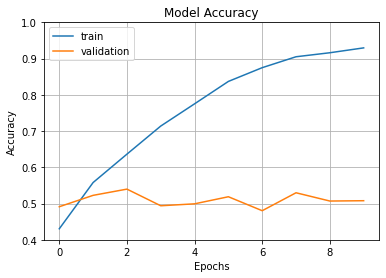

In [16]:
# plot the trend of training and validation accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [17]:
#save the model
model.save(best_model_path)

In [7]:
#load the test model
test_model = keras.models.load_model(best_model_path)

In [8]:
#predict the test data
df_p=pd.DataFrame(test_model.predict(test_ds))
df_p

211/211 [==============================] - 279s 1s/step


,0,1,2,3,4,5,6,7,8,9
0,0.266023,0.002675,0.064193,0.007990,0.144923,0.453508,0.019596,0.001010,0.001625,0.038458
1,0.000363,0.000002,0.000079,0.000017,0.002504,0.992122,0.000032,0.000005,0.000010,0.004867
2,0.078159,0.001218,0.057233,0.013488,0.000437,0.842571,0.001527,0.001806,0.000514,0.003048
3,0.198084,0.003047,0.014163,0.002690,0.381044,0.309908,0.082035,0.001238,0.001362,0.006428
4,0.011004,0.000800,0.196947,0.032229,0.483185,0.260003,0.004517,0.000540,0.001438,0.009337
...,...,...,...,...,...,...,...,...,...,...
3362,0.000962,0.001043,0.020579,0.069128,0.219771,0.542889,0.002180,0.011533,0.000663,0.131251
3363,0.014187,0.000608,0.005311,0.003360,0.418509,0.470465,0.004688,0.000472,0.000577,0.081824
3364,0.001766,0.000010,0.008298,0.002857,0.001207,0.985576,0.000129,0.000127,0.000015,0.000016
3365,0.019144,0.005171,0.436550,0.274064,0.039456,0.025517,0.002855,0.018103,0.008234,0.170906


In [9]:
#add the original label as the last column in the dataframe
test_label = np.concatenate([y for x, y in test_ds], axis=0) 
df_l=pd.DataFrame(test_label)
df_l
pd.concat([df_p,df_l],axis=1)

,0,1,2,3,4,5,6,7,8,9,0
0,0.266023,0.002675,0.064193,0.007990,0.144923,0.453508,0.019596,0.001010,0.001625,0.038458,0
1,0.000363,0.000002,0.000079,0.000017,0.002504,0.992122,0.000032,0.000005,0.000010,0.004867,0
2,0.078159,0.001218,0.057233,0.013488,0.000437,0.842571,0.001527,0.001806,0.000514,0.003048,0
3,0.198084,0.003047,0.014163,0.002690,0.381044,0.309908,0.082035,0.001238,0.001362,0.006428,0
4,0.011004,0.000800,0.196947,0.032229,0.483185,0.260003,0.004517,0.000540,0.001438,0.009337,0
...,...,...,...,...,...,...,...,...,...,...,...
3362,0.000962,0.001043,0.020579,0.069128,0.219771,0.542889,0.002180,0.011533,0.000663,0.131251,9
3363,0.014187,0.000608,0.005311,0.003360,0.418509,0.470465,0.004688,0.000472,0.000577,0.081824,9
3364,0.001766,0.000010,0.008298,0.002857,0.001207,0.985576,0.000129,0.000127,0.000015,0.000016,9
3365,0.019144,0.005171,0.436550,0.274064,0.039456,0.025517,0.002855,0.018103,0.008234,0.170906,9


In [11]:
#evaluate the model
test_model.evaluate(test_ds)

211/211 [==============================] - 302s 1s/step - loss: 1.9765 - accuracy: 0.4981


[1.976454734802246, 0.49806949496269226]